In [1]:
# default import, might be useless

# deep learning library
import torch
import torchvision
from   torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# to import data
import torchvision.transforms as transforms 
import torchvision.datasets.mnist as mnist  

# we use torch.cuda.Event(enable_timing=True) to measure time
# if you don't have cuda, you can use instead :
# from timeit import default_timer as timer
# import time

import collections           # for ordered_dictionnary
import torch.nn.init as init # to initialize model

import copy # for copy.deepcopy( ... )

import numpy as np

# to make and display plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 

# to format time to strings
import datetime                      

import math # for ceil ()

import IPython.display # to display .png

import time
import collections
import os
import sys
import torch
import torch.nn
from torch.autograd import Variable
import torch.nn as nn

from torch.distributions.normal import Normal
from torchvision.utils import *

import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import dataset
from torch import nn
# from torch.nn.modules import upsampling
# from torch.functional import F
from torch.optim import Adam

In [2]:
# Use the GPU if you have one
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda") 
else:
    print("WARNING: You are about to run on cpu")
    device = torch.device("cpu")


Using the GPU


In [3]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])


def get_data_loader(dataset_location, batch_size):
    trainvalid = torchvision.datasets.SVHN(
        dataset_location, split='train',
        download=True,
        transform=image_transform
    )

    trainset_size = int(len(trainvalid) * 0.9)
    trainset, validset = dataset.random_split(
        trainvalid,
        [trainset_size, len(trainvalid) - trainset_size]
    )

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    validloader = torch.utils.data.DataLoader(
        validset,
        batch_size=batch_size,
    )

    testloader = torch.utils.data.DataLoader(
        torchvision.datasets.SVHN(
            dataset_location, split='test',
            download=True,
            transform=image_transform
        ),
        batch_size=batch_size,
    )

    return trainloader, validloader, testloader

In [4]:
# sets are called train, valid, test
batch_size = 128
trainset, validset, testset = get_data_loader("svhn", batch_size)

Using downloaded and verified file: svhn\train_32x32.mat
Using downloaded and verified file: svhn\test_32x32.mat


In [11]:
# define decoder (generator) and critics (without batchnorm, with no sigmoid)

class UnFlatten(nn.Module):
    def __init__(self, n_channel=16, p_size=8 ):
        super(UnFlatten, self).__init__()
        self.n_channel = n_channel
        self.p_size    = p_size
        
    def forward(self, input):
        return input.view(input.size(0), self.n_channel, self.p_size, self.p_size).contiguous()

    
def make_GAN_decoder(z_dim=100,ngf=64,nc=3):
    decoder = nn.Sequential(
            # input is Z, going into a convolution
            UnFlatten(z_dim,1),
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.Conv2d( ngf, nc, 5, stride=1, padding=2, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )
    return decoder

def make_GAN_critic(ndf=64,nc=3):
    decoder = nn.Sequential(
        # bs : batch size 
        # input is bs x (nc) x 32 x 32
        nn.Conv2d(nc, ndf, 5, stride=1, padding=2, bias=False),
        nn.ReLU(inplace=True),
        # state size. bs x (ndf) x 32 x 32
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.ReLU(inplace=True),
        # state size. bs x (ndf*2) x 16 x 16
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.ReLU(inplace=True),
        # state size. bs x (ndf*4) x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.ELU(inplace=True),
        # state size. bs x (ndf*8) x 4 x 4
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
        # state size. bs x (1) x 1 x 1
        )
    return decoder

In [12]:
def number_of_params( net ) :
    nb_param  = 0
    depth     = 0 # count the number of different bias
    param_lst = " "
    for i, (key, value) in enumerate( net.state_dict().items() ) :
        if key.endswith("bias") :
            depth = depth + 1            
        nb_param_tmp = 1        
        for j , x in enumerate(value.size()) :               
            nb_param_tmp = nb_param_tmp * x                
        nb_param = nb_param + nb_param_tmp     
    return nb_param, depth

In [13]:
# the model :
model = make_GAN_decoder(z_dim=100,ngf=128,nc=3)
# model = make_GAN_critic(ndf=92,nc=3)
nparam, _ = number_of_params(model)
print(nparam)

12665732


In [14]:
# custom weights from DCGAN
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [15]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, ngf=128 ):
        super(Generator, self).__init__()
        self.main = make_GAN_decoder(z_dim,ngf)
        self.init()
        
    def init(self):
        self.apply(weights_init)
        
    def forward(self, input):
        return self.main(input)

class Critic(nn.Module):
    def __init__(self, ndf=92):
        super(Critic, self).__init__()
        self.main = make_GAN_critic(ndf)
        self.init()
        
    def init(self):
        self.apply(weights_init)
        
    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)
    
    def calc_gradient_penalty(self, bs, real_data, fake_data):
        # print "real_data: ", real_data.size(), fake_data.size()
        alpha = torch.rand(bs, 1, device=device)
        alpha = alpha.expand(bs, 3*32*32 ).contiguous().view(bs, 3, 32, 32)

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)
        interpolates = interpolates.requires_grad_()

        disc_interpolates = self.forward(interpolates)

        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size(),device=device),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]
        gradients = gradients.view(gradients.size(0), -1)

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

In [12]:
real_data = torch.empty(64,3,32,32).to(device)
fake_data = torch.empty(64,3,32,32).to(device)
res = netD.calc_gradient_penalty(64,real_data,fake_data)
print(res.shape)

NameError: name 'netD' is not defined

In [9]:
# sets are called train, valid, test
batch_size = 92
trainset, validset, testset = get_data_loader("svhn", batch_size)

Using downloaded and verified file: svhn\train_32x32.mat
Using downloaded and verified file: svhn\test_32x32.mat


In [16]:
# define models :
netD = Critic().to(device)
netG = Generator().to(device)

In [79]:
# want_save = True
want_save = False
if want_save :
    torch.save(netG.state_dict(), 'GAN_save/netG_checkpoint.pt')
    torch.save(netD.state_dict(), 'GAN_save/netD_checkpoint.pt')

In [12]:
want_load = True
# want_load = False
if want_load :
    load_dir   = "GAN_save/"
    fn_D       = "netD_checkpoint.pt"
    fn_G       = "netG_checkpoint.pt"
    PATH_D     = load_dir + fn_D
    PATH_G     = load_dir + fn_G
    netD.load_state_dict(torch.load(PATH_D))
    netG.load_state_dict(torch.load(PATH_G))

In [17]:
paramD = netD.parameters()
paramG = netG.parameters()
optimizerD = optim.Adam(paramD, lr=1e-4, betas=(0.5, 0.999), weight_decay=0, amsgrad=True) # *2
optimizerG = optim.Adam(paramG, lr=1e-4, betas=(0.5, 0.999), weight_decay=0, amsgrad=True)

In [ ]:
want_log     = False
want_samples = True
save_dir     = "GAN_save/samples/"

# hyperparam :
LAMBDA = 10
EPOCHS = 10
CRITIC_ITERS = 5    # How many critic iterations per generator iteration
OUTPUT_DIM   = 3072 # Number of pixels in SVHN (3*32*32)
BATCH_SIZE   = batch_size
DIM          = 100  # latent dimension

# fixed noise to show progress of generator
fixed_noise_32 = torch.randn(32, DIM,device=device)

start_time = time.time()
for epoch in range(EPOCHS):
    print("epoch : {e}, time spent since start : {t}".format( e=epoch, t=time.time()-start_time ) )
    netG.train()
    netD.train()
    for batch_idx_in_epoch, (real_data, _) in enumerate(trainset):
        if batch_idx_in_epoch % 100 == 0 :
            print("progress : {p}%".format(p=batch_idx_in_epoch*100//len(trainset)))
            if want_samples : 
                with torch.no_grad():
                    file_samples = save_dir + "{date:%H%M%S}.jpg".format( date=datetime.datetime.now() )
                    gen_from_fixed_noise = netG(fixed_noise_32)
                    grid_img = torchvision.utils.save_image(gen_from_fixed_noise.cpu(), file_samples, nrow=8, normalize=True)
                
        if real_data.size(0) != BATCH_SIZE: # if necessary, skip the last batch
            continue 
        
        # index of current batch from the beginning of training
        batch_idx = epoch * len(trainset) + batch_idx_in_epoch
        
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()

        real_data = real_data.to(device)

        # train with real
        r_output  = netD(real_data)
        errD_real = r_output.mean()
        D_x       = errD_real.item()

        # train with fake
        noise = torch.randn(BATCH_SIZE, DIM, device=device)
        with torch.no_grad():
            fake = netG(noise)
        f_output = netD(fake.detach())
        errD_fake = f_output.mean()
        D_G_z1    = errD_fake.item()

        # train with gradient penalty
        gradient_penalty = LAMBDA * netD.calc_gradient_penalty(BATCH_SIZE, real_data.data, fake.data)

        # print("gradien_penalty: ", gradient_penalty)

        D_cost = errD_fake - errD_real + gradient_penalty
        D_cost.backward()
        optimizerD.step()
        
        Wasserstein_D = D_x - D_G_z1
        # plot('./train disc cost'     , D_cost.item())
        # plot('./wasserstein distance', Wasserstein_D)
        
        ############################
        # (2) Update G network
        ###########################
        if (batch_idx + 1) % CRITIC_ITERS == 0:
            for p in netD.parameters():
                p.requires_grad = False  # to avoid computation
            netG.zero_grad()
            noise    = torch.randn(BATCH_SIZE, DIM, device=device)
            fake     = netG(noise)
            f_output = netD(fake)
            errG     = -f_output.mean()
            D_G_z2   =  f_output.mean().item()
            
            errG.backward()
            optimizerG.step()

            # # Write logs and save samples
            # plot('./time', time.time() - start_time)
            # plot('./train gen cost', D_G_z2)

            for p in netD.parameters():  # reset requires_grad
                p.requires_grad = True  # they are set to False below in netG update
        
        if want_log :
            ############################
            # (3) Logging
            ###########################
            # Calculate inception score every 1K iters
            if False and (batch_idx + 1) % (CRITIC_ITERS*1000) == 0:
                inception_score = get_inception_score(netG)
                plot('./inception score', inception_score[0].squeeze())

            # Calculate dev loss and generate samples every 100 iters
            if (batch_idx + 1) % (CRITIC_ITERS*100) == 0:
                plot('./dev disc cost', evaluate(netD, test))
                with torch.no_grad():
                    samples = netG(fixed_noise_32)
                imshow(torchvision.utils.make_grid(samples), batch_idx)
                flush()
                tick()

    torch.save(netG.state_dict(), 'GAN_save/netG_{}.pt'.format(epoch))
    torch.save(netD.state_dict(), 'GAN_save/netD_{}.pt'.format(epoch))

epoch : 0, time spent since start : 0.0
progress : 0%
progress : 13%
progress : 27%
progress : 41%


# Qualitative evaluation

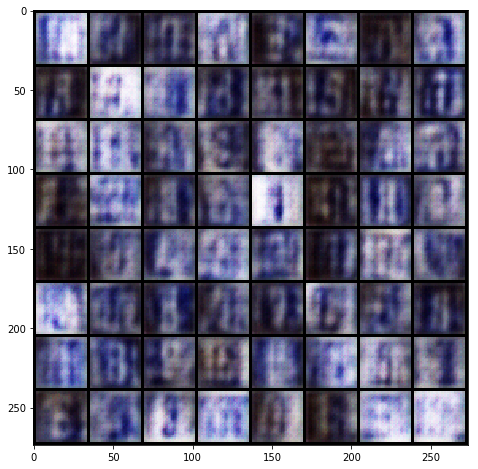

In [16]:
plt.figure(figsize=(8,8))
model.eval()
generator = netG
with torch.no_grad() :
    z_dim = 100
    bs    = 64
    mu    = torch.zeros(bs,z_dim)
    std   = torch.ones(bs,z_dim)
    z     = mu + 1.0 * std * torch.randn_like(std)
    z     = z.to(device)
    gen   = generator(z)
    gen_  = gen.cpu()
    # gen_  = gen_ - gen_.min()
    # gen_  = gen_ / gen_.max()
    # print(gen_.shape)
    # imshow(torchvision.utils.make_grid(gen_))
    grid_img = torchvision.utils.make_grid(gen_.cpu(), nrow=8, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))